![]()

# Face Classification for Diffrent Facial Attributes

# 1. Import 


In [1]:
# System
import sys
import os
import argparse

# Time
import time
import datetime

# Numerical Data
import random
import numpy as np 
import pandas as pd

# Tools
import shutil
from glob import glob
from tqdm import tqdm
import gc

# NLP
import re

# Preprocessing
from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn.utils import shuffle

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Machine Learning Models
from sklearn import svm
from sklearn.svm import LinearSVC, SVC

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score


# Deep Learning - Keras -  Preprocessing
from keras.preprocessing.image import ImageDataGenerator

# Deep Learning - Keras - Model
import keras
from keras import models
from keras.models import Model
from keras.models import Sequential

# Deep Learning - Keras - Layers
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPool2D, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras.layers.pooling import _GlobalPooling1D

from keras.regularizers import l2

# Deep Learning - Keras - Pretrained Models
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile, NASNetLarge

from keras.applications.nasnet import preprocess_input

# Deep Learning - Keras - Model Parameters and Evaluation Metrics
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy

# Deep Learning - Keras - Visualisation
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
# from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

# Deep Learning - TensorFlow
import tensorflow as tf

# Graph/ Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

# Image
import cv2
from PIL import Image
from IPython.display import display

# np.random.seed(42)

%matplotlib inline

# Input data
print(os.listdir("../input/"))

Using TensorFlow backend.


['list_bbox_celeba.csv', 'list_eval_partition.csv', 'list_landmarks_align_celeba.csv', 'list_attr_celeba.csv', 'img_align_celeba']


# 2. Functions

In [2]:
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()  

# 3. Input Configuration

In [3]:
input_directory = r"../input/"
output_directory = r"../output/"

training_dir = input_directory + "img_align_celeba/img_align_celeba"
testing_dir = input_directory + "img_align_celeba/img_align_celeba"

if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
figure_directory = "../output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

In [4]:
train_df2 = pd.read_csv(input_directory + "list_attr_celeba.csv")
train_df2.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [5]:
ID = "image_id"
label = "Attractive"

train_df = pd.DataFrame({"id": train_df2[ID], "label": train_df2[label]})
train_df["label"] = train_df["label"].apply(lambda x: "Yes" if x==1 else "No")
train_df.head()

,id,label
0,000001.jpg,Yes
1,000002.jpg,No
2,000003.jpg,No
3,000004.jpg,Yes
4,000005.jpg,Yes


In [6]:
classes = train_df.label.unique()

In [7]:
test_df = pd.DataFrame({"id": train_df.id[182637:], "label": "No"}, index=None).reset_index(drop=True)
test_df.head()

,id,label
0,182638.jpg,No
1,182639.jpg,No
2,182640.jpg,No
3,182641.jpg,No
4,182642.jpg,No


In [8]:
train_df = train_df[:182636]

In [9]:
len(train_df), len(test_df)

(182636, 19962)

In [10]:
all_columns = train_df.columns
columns = [col for col in all_columns if not col=="id"]
columns

['label']

# 4. Visualization

In [11]:
def plot_image(file, directory=None, sub=False, aspect=None):
    path = directory + "/" + file
    
    img = plt.imread(path)
    
    plt.imshow(img, aspect=aspect)
#     plt.title(file)
    plt.xticks([])
    plt.yticks([])
    
    if sub:
        plt.show()
        
def plot_img_dir(directory=training_dir, count=5):
    selected_files = random.sample(os.listdir(directory), count)
    
    ncols = 5
    nrows = count//ncols if count%ncols==0 else count//ncols+1
    
    figsize=(20, ncols*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    
    for file in selected_files:        
        plt.subplot(nrows, ncols, i+1)
        path = directory + file
        plot_image(file, directory, aspect=None)

        i=i+1
    
    plt.tight_layout()
    plt.show()
    
def plot_img_df(directory=None, df=None, filename="id", label = "label", count=5):
    label_map = {}
    
    classes = list(set(df[label]))
    
    for l in classes:
        label_map[l] = df[df[label]==l][filename]
        label_map[l] = label_map[l].sample(count, replace=True)
        
    
    
    ncols = 5
    nrows = count//ncols if count%ncols==0 else count//ncols+1
#     print(nrows, ncols)
    
    figsize=(20, ncols*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    
    for label in label_map:
        print(label)
        j=0
        for id, file in label_map[label].iteritems():
            plt.subplot(nrows, 5, j+1)
            plot_image(file, directory, aspect='auto')
            j=j+1
            
        plt.tight_layout()
        plt.show()
        
        i+=1
        
def plot_img_dir_main(directory=training_dir, count=5):
    labels = os.listdir(directory)
    for label in labels:
        print(label)
        plot_img_dir(directory=directory+"/"+label, count=count)
        

label
Yes


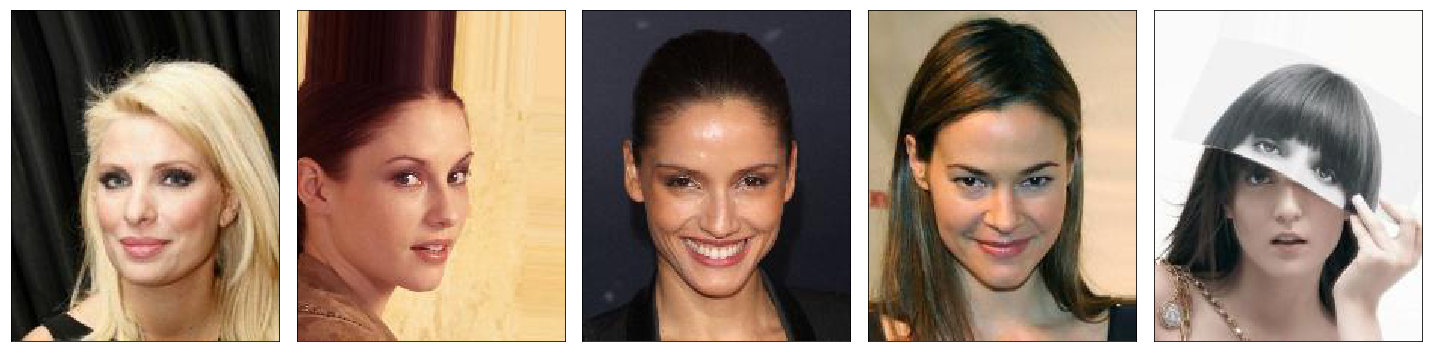

No


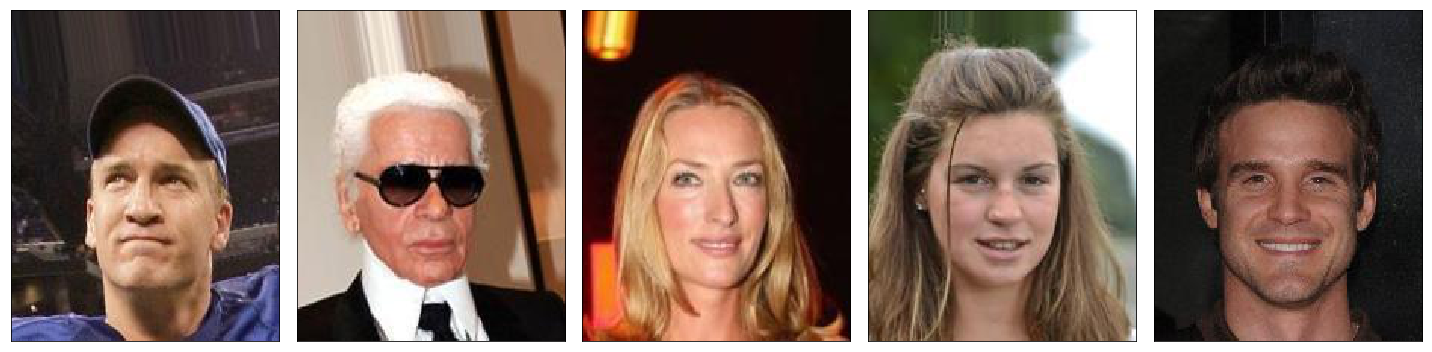

In [12]:
for col in columns:
    print(col)
    plot_img_df(directory=training_dir, df=train_df, filename="id", label=col, count=5)
    print("")

label


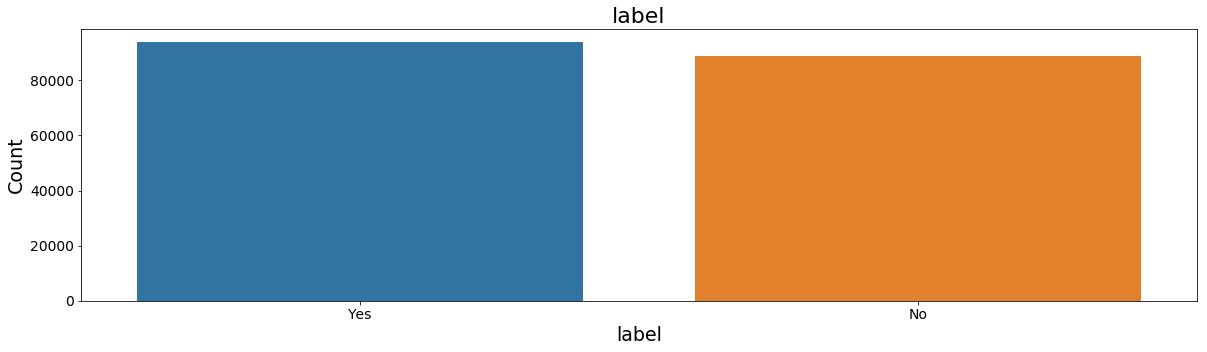

In [13]:
for col in columns:
    print(col)
    m = {-1: "Not "+col, 1:col}
    ax = sns.countplot(train_df[col])
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
#     plt.xticks(m)
    plt.show()

# 5. Preprocess

During Preprocessing, all of the image has been transformed to target size (224, 224) and pixel value has been rescaled to unit value. (224, 224) is the input shape for Pretrained model "NashNetMobile". The target class is treated as categorical and both training and validation image set has been re-shuffled. Some of the images has been horizontally and vertically flipped randomly and sheerness and rotation has been changed to introduce heterogeneity. A part of training dataset has been used as validation set. 

In [ ]:
def get_data(batch_size=32, target_size=(299, 299), class_mode="categorical", training_dir=training_dir, testing_dir=testing_dir, x_col="id", y_col="label"):
    print("Preprocessing and Generating Data Batches.......\n")
    
    rescale = 1.0/255

    train_batch_size = batch_size
    validation_batch_size = batch_size*5
    test_batch_size = batch_size*5
    
    train_shuffle = True
    val_shuffle = True
    test_shuffle = False
    
    train_datagen = ImageDataGenerator(
#         horizontal_flip=True,
#         vertical_flip=True,
#         rotation_range=15,
#         shear_range=1,
        rescale=rescale,
        validation_split=0.25)

    train_generator = train_datagen.flow_from_dataframe(
        train_df, 
        training_dir,
        x_col=x_col,
        y_col=y_col,  
        target_size=target_size, 
#         classes=classes,
        class_mode=class_mode, 
        batch_size=batch_size, 
        shuffle=True, 
        seed=42,
        subset='training')
    
    
    validation_generator = train_datagen.flow_from_dataframe(
        train_df, 
        training_dir,
        x_col=x_col,
        y_col=y_col,  
#         classes=classes,
        target_size=target_size, 
        class_mode=class_mode, 
        batch_size=validation_batch_size, 
        shuffle=True, 
        seed=42,
        subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=rescale)
    
    test_generator = test_datagen.flow_from_dataframe(
        test_df, 
        testing_dir,
        x_col=x_col,
        y_col=y_col,  
#         classes=classes,
        target_size=target_size, 
        class_mode=class_mode, 
        batch_size=test_batch_size, 
        shuffle=False, 
        seed=42)
    
    class_weights = get_weight(train_generator.classes)
    
    steps_per_epoch = len(train_generator)
    validation_steps = len(validation_generator)
    
    print("\nPreprocessing and Data Batch Generation Completed.\n")
    
    
    return train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps
            
# Calculate Class Weights
def get_weight(y):
    class_weight_current =  cw.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current


# 5. Model Function

In [ ]:
def get_model(model_name, input_shape=(96, 96, 3), num_class=2, weights='imagenet', dense_units=1024):
    inputs = Input(input_shape)
    
    if model_name == "Xception":
        base_model = Xception(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet50":
        base_model = ResNet50(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet101":
        base_model = keras.applications.resnet.ResNet101(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet152":
        base_model = keras.applications.resnet.ResNet152(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet50V2":
        base_model = resnet_v2.ResNet50V2(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet101V2":
        base_model = resnet_v2.ResNet101V2(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNet152V2":
        base_model = resnet_v2.ResNet152V2(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNeXt50":
        base_model = resnext.ResNeXt50(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "ResNeXt101":
        base_model = resnext.ResNeXt101(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "InceptionV3":
        base_model = InceptionV3(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "InceptionResNetV2":
        base_model = InceptionResNetV2(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "DenseNet201":
        base_model = DenseNet201(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "NASNetMobile":
        base_model = NASNetMobile(include_top=False, weights=weights, input_shape=input_shape)
    elif model_name == "NASNetLarge":
        base_model = NASNetLarge(include_top=False, weights=weights, input_shape=input_shape)
            
    
    x = base_model.output
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(dense_units)(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    x = Dropout(0.5)(x)
    
    if num_class>1:
        outputs = Dense(num_class, activation="softmax")(x)
    else:
        outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    
    model.summary()
    
    
    return model


def get_conv_model(num_class=2, input_shape=(150,150, 3)):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D())
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D())
    model.add(Dropout(0.2))

    model.add(GlobalAveragePooling2D())
    
    if num_class>1:
        model.add(Dense(num_class, activation='softmax'))
    else:
        model.add(Dense(num_class, activation='sigmoid'))
    
#     print(model.summary())

    return model

# 6. Output Configuration

In [ ]:
main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"

try:
    os.mkdir(main_model_dir)
except:
    print("Could not create main model directory")
    
try:
    os.mkdir(main_log_dir)
except:
    print("Could not create main log directory")



model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')


try:
    os.mkdir(model_dir)
except:
    print("Could not create model directory")
    
try:
    os.mkdir(log_dir)
except:
    print("Could not create log directory")
    
model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

## 6.2 Call Back Configuration

In [ ]:
print("Settting Callbacks")

def step_decay(epoch, lr):
    # initial_lrate = 1.0 # no longer needed
    lrate = lr
    if epoch==2:
        lrate = 0.0001  
#     lrate = lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1,
    restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=0.0000001,
    verbose=1)

learning_rate_scheduler = LearningRateScheduler(step_decay, verbose=1)
# f1_metrics = Metrics()


callbacks = [reduce_lr, early_stopping]
# callbacks = [checkpoint, reduce_lr, early_stopping]
# callbacks = [reduce_lr, early_stopping, f1_metrics]

print("Set Callbacks at ", date_time(1))

# 7. Model

In [ ]:
print("Getting Base Model", date_time(1))

dim = 96
# dim = 224
# dim = 299

input_shape = (dim, dim, 3)


num_class = 2

weights = 'imagenet'
dense_units = 128

model = get_model(model_name="InceptionV3", input_shape=input_shape, num_class=num_class, weights=weights, dense_units=dense_units)
# model = get_conv_model(num_class=num_class, input_shape=input_shape)
print("Loaded Base Model", date_time(1))

In [ ]:
loss = 'categorical_crossentropy'
# loss = 'binary_crossentropy'
metrics = ['accuracy']
# metrics = [auroc]

# 8. Data

In [ ]:
batch_size = 64

class_mode = "categorical"
# class_mode = "binary"

target_size = (dim, dim)

train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps = get_data(batch_size=batch_size, target_size=target_size, class_mode=class_mode)    


# 9. Training

Trained model on full tranning dataset for 10 epochs and validated on full validation dataset. Adjusted class weight has been used for trainning. For optimization used Adam optimizer with learning rate of 0.0001. For loss calculation used categorical crossentropy and for model performance evaluation used accuracy metrics.  

In [ ]:
# print("Starting Trainning ...\n")

# start_time = time.time()
# print(date_time(1))

# # batch_size = 32
# # train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps = get_data(batch_size=batch_size)

# print("\n\nCompliling Model ...\n")
# # learning_rate = 0.0001
# # optimizer = Adam(learning_rate)
# optimizer = Adam()

# model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# steps_per_epoch = 150
# validation_steps = 50

# verbose = 1
# epochs = 2

# print("Trainning Model ...\n")
# history = model.fit_generator(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=epochs,
#     verbose=verbose,
#     callbacks=callbacks,
#     validation_data=validation_generator,
#     validation_steps=validation_steps, 
#     class_weight=class_weights)

# elapsed_time = time.time() - start_time
# elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

# print("\nElapsed Time: " + elapsed_time)
# print("Completed Model Trainning", date_time(1))

In [ ]:
print("Starting Trainning ...\n")

start_time = time.time()
print(date_time(1))

# batch_size = 32
# train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps = get_data(batch_size=batch_size)

print("\n\nCompliling Model ...\n")
learning_rate = 0.0001
optimizer = Adam(learning_rate)
# optimizer = Adam()

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

verbose = 1
epochs = 20

print("Trainning Model ...\n")
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weights)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", date_time(1))

# 10. Model Performance 
Model Performance  Visualization over the Epochs

In [ ]:
def plot_performance(history=None, figure_directory=None):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    ylim_pad = [0.005, 0.005]
    ylim_pad = [0, 0]


    plt.figure(figsize=(20, 5))

    # Plot training & validation Accuracy values

    y1 = history.history['acc']
    y2 = history.history['val_acc']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]
    
#     min_y = .96
#     max_y = 1


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()


    # Plot training & validation loss values

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]

#     min_y = .1
#     max_y = 0

    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [ ]:
plot_performance(history=history)

In [ ]:
ypreds = model.predict_generator(generator=test_generator, steps = len(test_generator),  verbose=1)
# ypreds

In [ ]:
ypred = ypreds.argmax(axis=-1)
# ypred

In [ ]:
count = 5

ncols = 5
nrows = count//ncols if count%ncols==0 else count//ncols+1

figsize=(20, ncols*nrows)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5


params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


for label in set(train_generator.classes):
    print(label)
    x = np.where(ypred == 1)[0].tolist()
    s = np.random.choice(x, count)
    j=0
    for index in s:
        file = test_generator.filenames[index]
#         print(file)
        plt.subplot(nrows, 5, j+1)
        plot_image(file, training_dir, aspect='auto')
        j=j+1

    plt.tight_layout()
    plt.show()
        

In [ ]:
test_df = pd.DataFrame({'id': test_generator.filenames,'label': ypred})

test_df.to_csv('submission.csv', index=False)
test_df.head()